In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
WINDOW_SIZE = 24
FORECAST_PERIOD = 24
BATCH_SIZE = 32
LABEL_NAME = 'T (degC)'

In [3]:
df_train, df_val, df_test = utils.load_data()
print(f"df_train.shape = {df_train.shape}, df_val.shape = {df_val.shape}, df_test.shape = {df_test.shape}")

df_train.shape = (49063, 19), df_val.shape = (14018, 19), df_test.shape = (7010, 19)


In [4]:
df_train.iloc[:3]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.366064,-0.366026,-0.069373,1.427981
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.414249,0.000015,-0.068349,1.427977
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.366064,0.366057,-0.067326,1.427971


In [5]:
df_train.iloc[24:27]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
149,1.287581,-1.565371,-1.653338,-1.404076,1.117102,-1.165095,-1.237319,-0.777970,-1.247935,-1.247958,1.867186,0.177090,0.345484,0.036193,0.472518,-1.366064,-0.366026,-0.044820,1.427669
155,1.238168,-1.548040,-1.632707,-1.382562,1.123142,-1.158597,-1.225438,-0.780045,-1.232961,-1.236221,1.836666,0.083946,0.094777,0.063481,0.103854,-1.414249,0.000015,-0.043797,1.427647
161,1.209244,-1.566526,-1.648754,-1.398339,1.141263,-1.165095,-1.234943,-0.782121,-1.244192,-1.245611,1.848142,-0.001395,0.086076,0.013978,0.119807,-1.366064,0.366057,-0.042774,1.427624


In [6]:
label_idx = list(df_train.columns).index(LABEL_NAME)

In [7]:
def build_dataset(df_data, window_size, forecast_period, label_idx, batch_size, shuffle=True):
    data = np.array(df_data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size + forecast_period,
        sequence_stride=window_size,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    # Note: Use batched_window[:, 1: ...
    ds = ds.map(lambda batched_window: (batched_window[:, :window_size, :],
                                        batched_window[:, window_size:, label_idx:label_idx+1]))
    return ds

In [8]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, label_idx, BATCH_SIZE, shuffle=False)

for x_batch, y_batch in train_ds.take(1):
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"x_batch[0, :3] = \n{x_batch[0, :3]}")
    print(f"y_batch.shape = {y_batch.shape}")
    print(f"y_batch[0, :3] = \n{y_batch[0, :3]}")

x_batch.shape = (32, 24, 19)
x_batch[0, :3] = 
[[ 9.45307612e-01 -1.98247325e+00 -2.04188848e+00 -1.91897273e+00
   1.11710155e+00 -1.30285120e+00 -1.47732317e+00 -7.90423632e-01
  -1.48003638e+00 -1.48269725e+00  2.21852374e+00  1.93409234e-01
   2.21161291e-01  1.11140452e-01  2.17927873e-01 -1.36606407e+00
  -3.66026342e-01 -6.93725795e-02  1.42798138e+00]
 [ 9.59769845e-01 -2.07837200e+00 -2.13816643e+00 -2.06096363e+00
   1.04461730e+00 -1.33014262e+00 -1.53435397e+00 -7.86272287e-01
  -1.53618979e+00 -1.53903449e+00  2.32570744e+00  1.72986776e-01
   2.22100869e-01  1.09458245e-01  2.27798492e-01 -1.41424906e+00
   1.52973589e-05 -6.83494657e-02  1.42797673e+00]
 [ 9.86283958e-01 -2.07028437e+00 -2.13243556e+00 -2.04518700e+00
   1.06273842e+00 -1.32884300e+00 -1.52722502e+00 -7.88347960e-01
  -1.52870274e+00 -1.53199232e+00  2.32399845e+00  2.07982704e-01
   2.76266009e-01  1.11218050e-01  3.24078411e-01 -1.36606407e+00
   3.66056949e-01 -6.73263520e-02  1.42797124e+00]]
y_batch

In [9]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, label_idx, BATCH_SIZE)
val_ds = build_dataset(df_val, WINDOW_SIZE, FORECAST_PERIOD, label_idx, BATCH_SIZE)

In [10]:
model = keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    keras.layers.Lambda(lambda x: x[:, -1:, :]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(FORECAST_PERIOD, kernel_initializer=tf.initializers.zeros),
    keras.layers.Reshape([FORECAST_PERIOD, 1])
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds, 
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
64/64 [==============================] - 1s 8ms/step - loss: 0.2409 - mean_absolute_error: 0.3528 - val_loss: 0.1368 - val_mean_absolute_error: 0.2757
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0900 - mean_absolute_error: 0.2244 - val_loss: 0.1091 - val_mean_absolute_error: 0.2479
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0836 - mean_absolute_error: 0.2153 - val_loss: 0.1137 - val_mean_absolute_error: 0.2521
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0820 - mean_absolute_error: 0.2131 - val_loss: 0.1090 - val_mean_absolute_error: 0.2506
Epoch 5/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0793 - mean_absolute_error: 0.2093 - val_loss: 0.1176 - val_mean_absolute_error: 0.2584
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 0.0804 - mean_absolute_error: 0.2111 - val_loss: 0.1125 - val_mean_absolute_error: 0.2529


In [11]:
new_data = df_val.iloc[:WINDOW_SIZE].to_numpy()
new_data = np.expand_dims(new_data, 0)
forecast = model.predict(new_data)
forecast = tf.squeeze(forecast).numpy()
actual = df_val.iloc[WINDOW_SIZE:WINDOW_SIZE + FORECAST_PERIOD][LABEL_NAME].to_numpy()

In [12]:
utils.evaluate(actual, forecast)

mse = 0.0153, mae = 0.1107


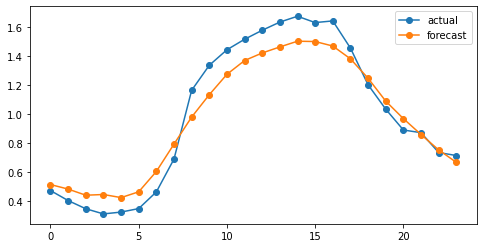

In [13]:
utils.plot_result(actual, forecast)